# 전반적인 데이터 체크와 마켓 인덱스 뽑아보기


    특이사항
1. price = 0이 1591개 존재함
2. 음수 mktcap이 6개 존재함
3. BTC의 weight가 갑자기 변하는 날이 존재함




    coingecko에서 따로 찾은 값으로 수정했음

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
# Data Loading and pivot
data = pd.read_pickle("cmktcap_data_raw.pickle")

close = pd.pivot_table(data=data, values="close",
                       index="date",columns="coin_id")

mktcap = pd.pivot_table(data=data, values="mktcap",
                        index="date",columns="coin_id")

vol = pd.pivot_table(data=data, values="vol",
                     index="date",columns="coin_id")

In [3]:
# 전처리 해준건 여기다가 저장
close_pp = close.copy()
mktcap_pp = mktcap.copy()

In [4]:
mktcap_mask = (mktcap > 1_000_000).replace({True:1,
                                            False:np.nan})

mktcap_screened = (mktcap * mktcap_mask)

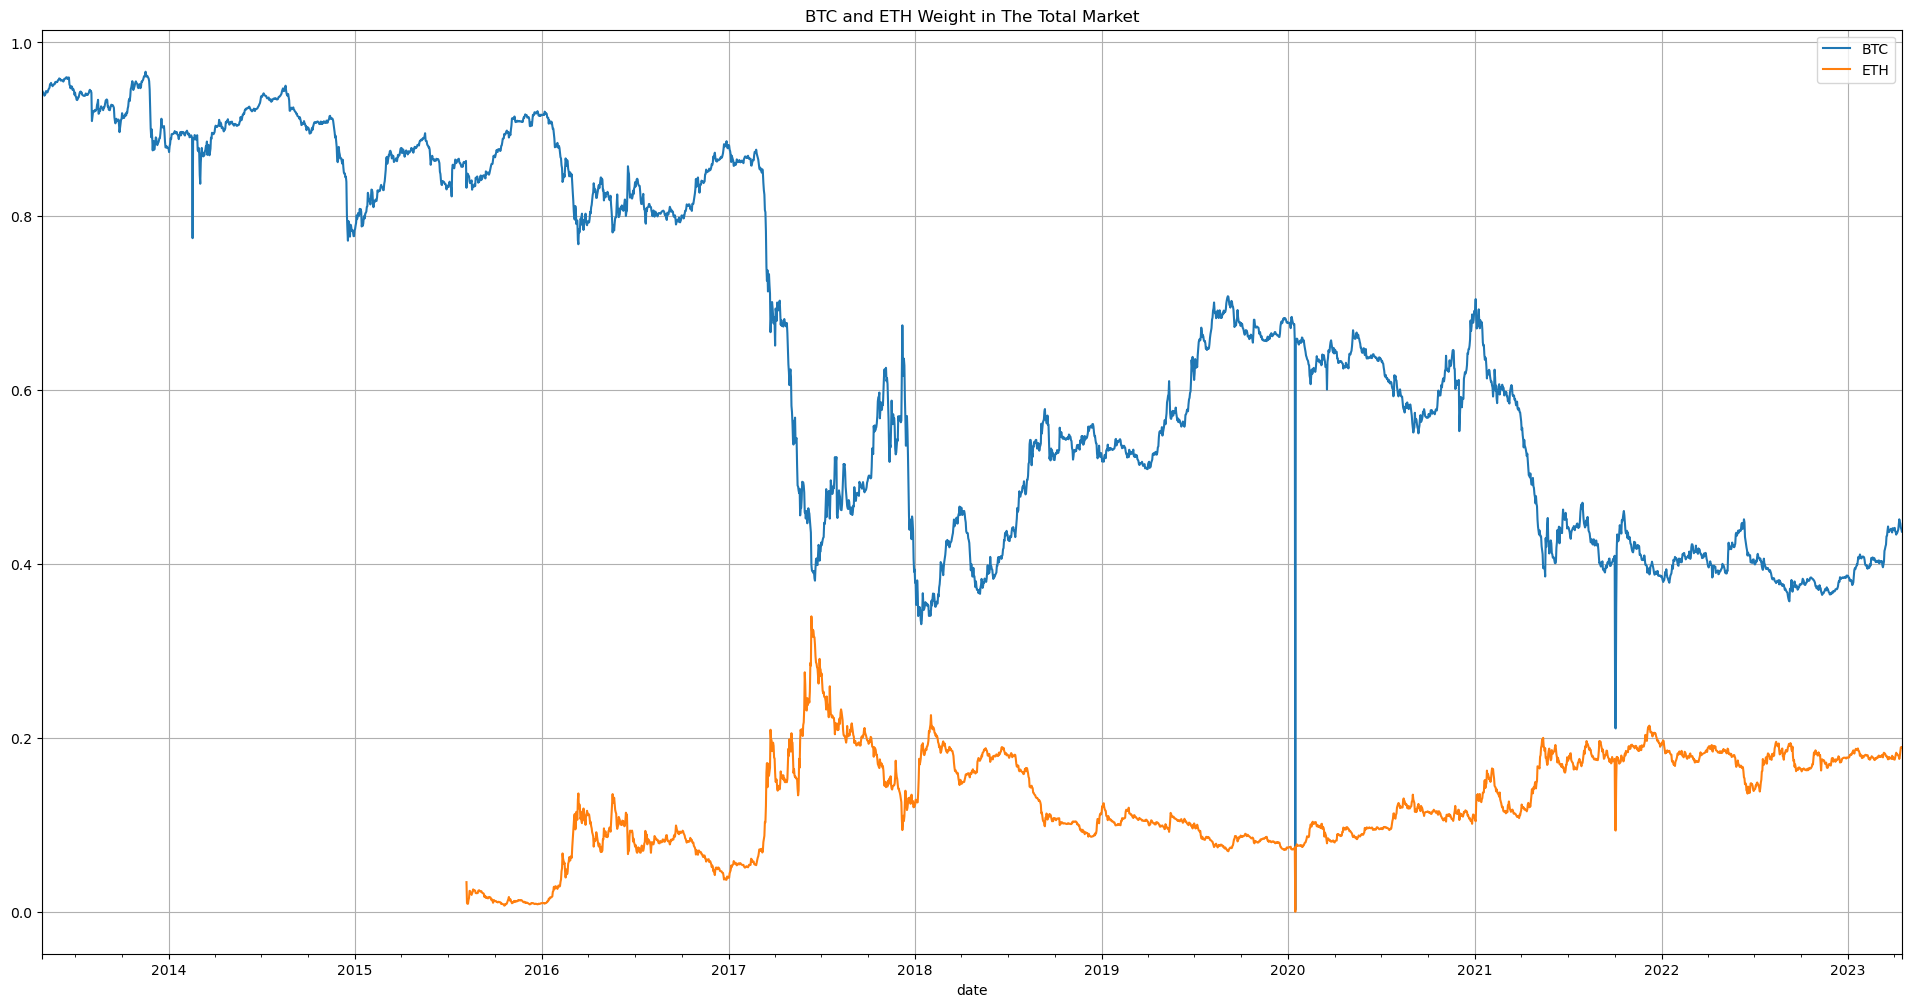

In [23]:
weight = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
weight[["1","1027"]].plot(figsize=(24,12))
plt.grid()
plt.title("BTC and ETH Weight in The Total Market")
plt.legend(["BTC","ETH"]);

### 1. Price == 0 Check!

In [6]:
# price가 0인게 1591개가 존재한다. 
(close == 0).sum().sum()

1591

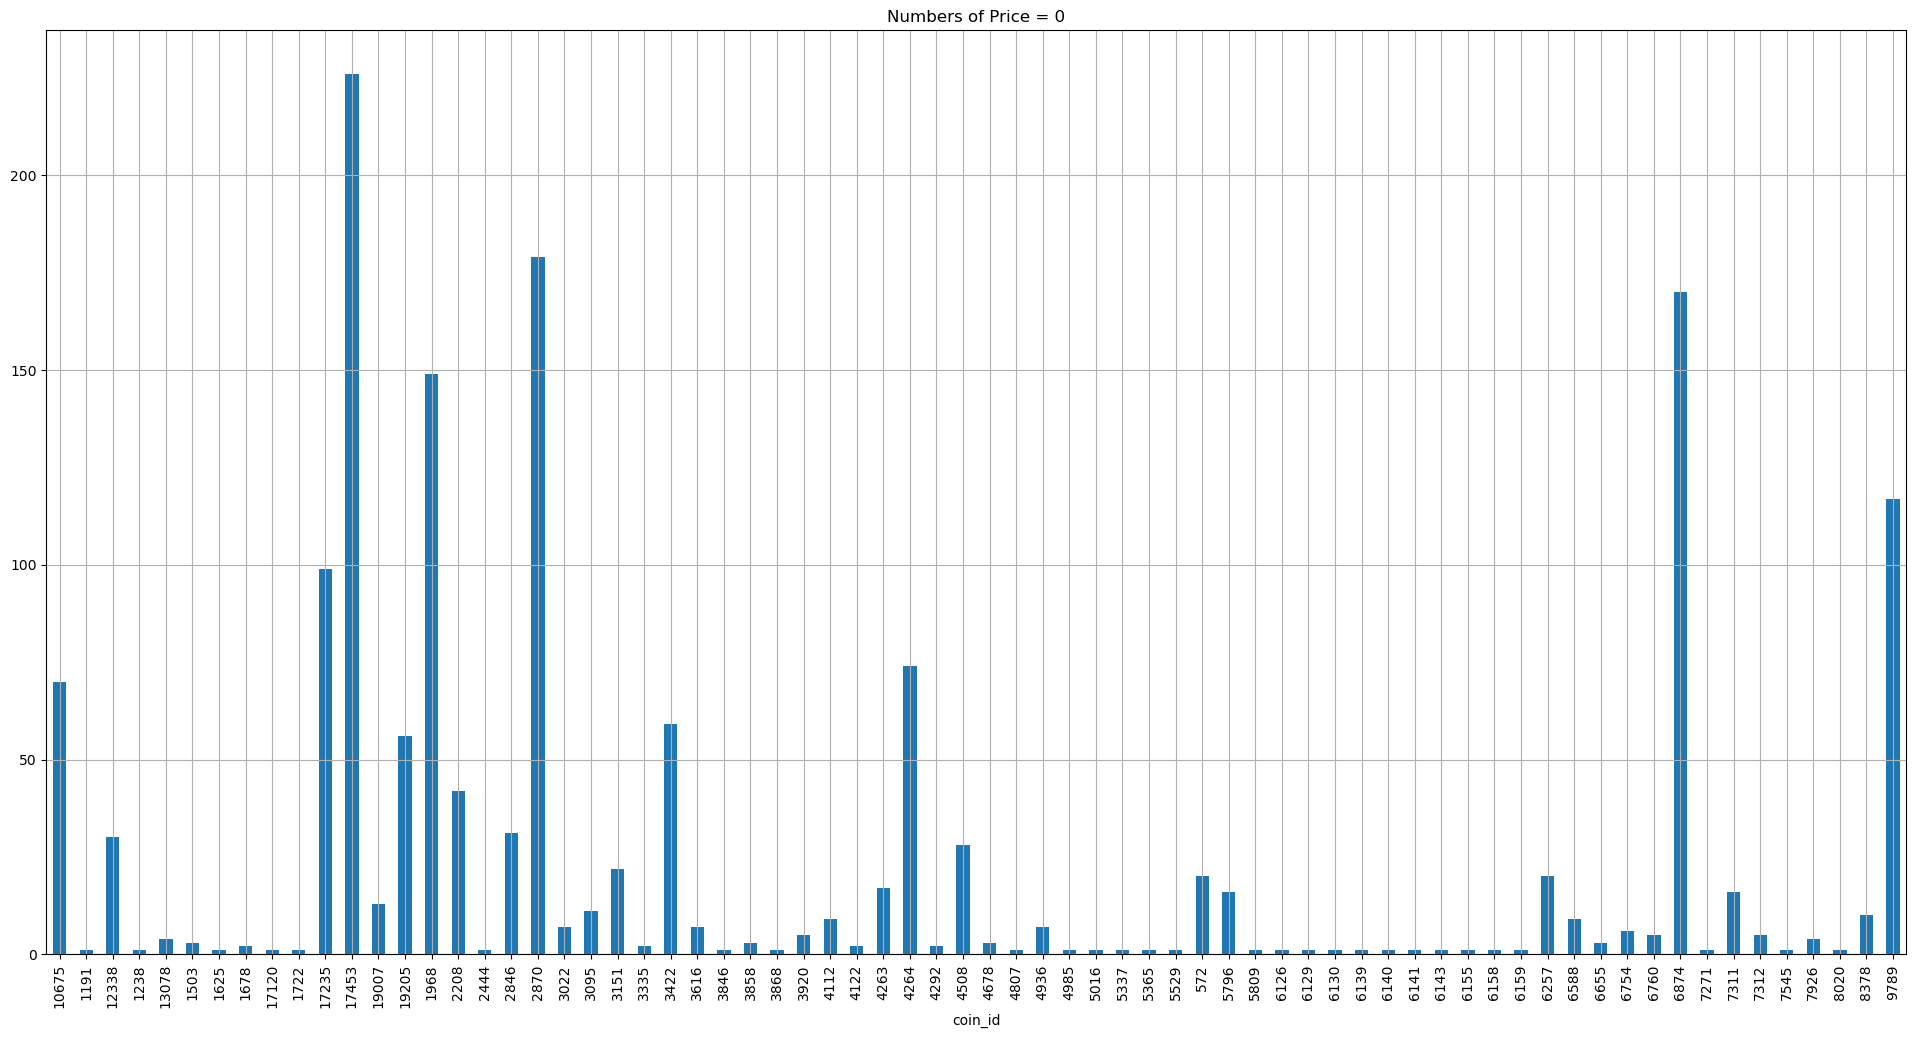

In [42]:
# price가 0인 코인들 출력
(close == 0).sum().loc[(close==0).sum() >= 1].plot(kind="bar",
                                                   figsize=(24,12))
plt.title("Numbers of Price = 0")
plt.grid();

In [8]:
# price가 0이 있으면 rtn이 inf가 찍히는 문제가 있다 -> replace to np.nan
rtn_daily = close.replace(0, np.nan).pct_change(fill_method=None)

### 2. mktcap 음수 값 Check!

LUA는 coingecko에서 데이터 찾아뒀음

ZNZ는 coingecko에서 데이터 찾아뒀음

In [9]:
# 음수 값 있는지 확인
print((close < 0).sum().sum())
print((mktcap < 0).sum().sum()) # 6 times 
print((vol < 0).sum().sum())

0
6
0


In [10]:
# mktcap 음수 확인
negative = (mktcap < 0).sum()
negative.loc[negative > 0]

# 4286: ZENZO(ZNZ) / 7216: LuaSwap(LUA)

coin_id
4286    3
7216    3
dtype: int64

In [11]:
coin = "4286"
start, end = "2021-05-28", "2021-06-03"
p1_m = mktcap[[coin]].loc[start:end]
p1_c = close[[coin]].loc[start:end]

pd.concat([p1_m, p1_c], axis=1,
          keys=["mktcap","price"])

,mktcap,price
coin_id,4286,4286
date,,
2021-05-28,784871.66,0.056650
2021-05-29,774625.29,0.055910
2021-05-30,-68.05,0.056153
2021-05-31,-76.21,0.062882
2021-06-01,-74.81,0.061725
2021-06-02,1905878.69,0.064242
2021-06-03,2018694.49,0.068045


In [12]:
coin = "7216"
start, end = "2021-03-13", "2021-03-19"
p2_m = mktcap[[coin]].loc[start:end]
p2_c = close[[coin]].loc[start:end]

pd.concat([p2_m, p2_c], axis=1,
          keys=["mktcap","price"])

,mktcap,price
coin_id,7216,7216
date,,
2021-03-13,0.00,0.139239
2021-03-14,0.00,0.144501
2021-03-15,-14026210.14,0.137392
2021-03-16,-11707430.57,0.114719
2021-03-17,-12874285.45,0.126152
2021-03-18,8129720.66,0.126900
2021-03-19,7905651.99,0.123287


In [13]:
# 만약 coingecko 데이터로 클리닝 한다면...
# 4286: ZNZ / 7216: LUA

# ZNZ : 1_375_677 / 1_311_062 / 1_346_169 (2021-05-30 : 2021-06-01)
# LUA : 8_995_771 / 8_526_111 / 8_111_398 (2021-03-15 : 2021-03-17)

mktcap_pp.loc["2021-05-30":"2021-06-01", "4286"] = [1_375_677, 1_311_062, 1_346_169]
mktcap_pp.loc["2021-03-15":"2021-03-17", "7216"] = [8_995_771, 8_526_111, 8_111_398]

### 3. BTC weight가 이상한 날을 잡아보자

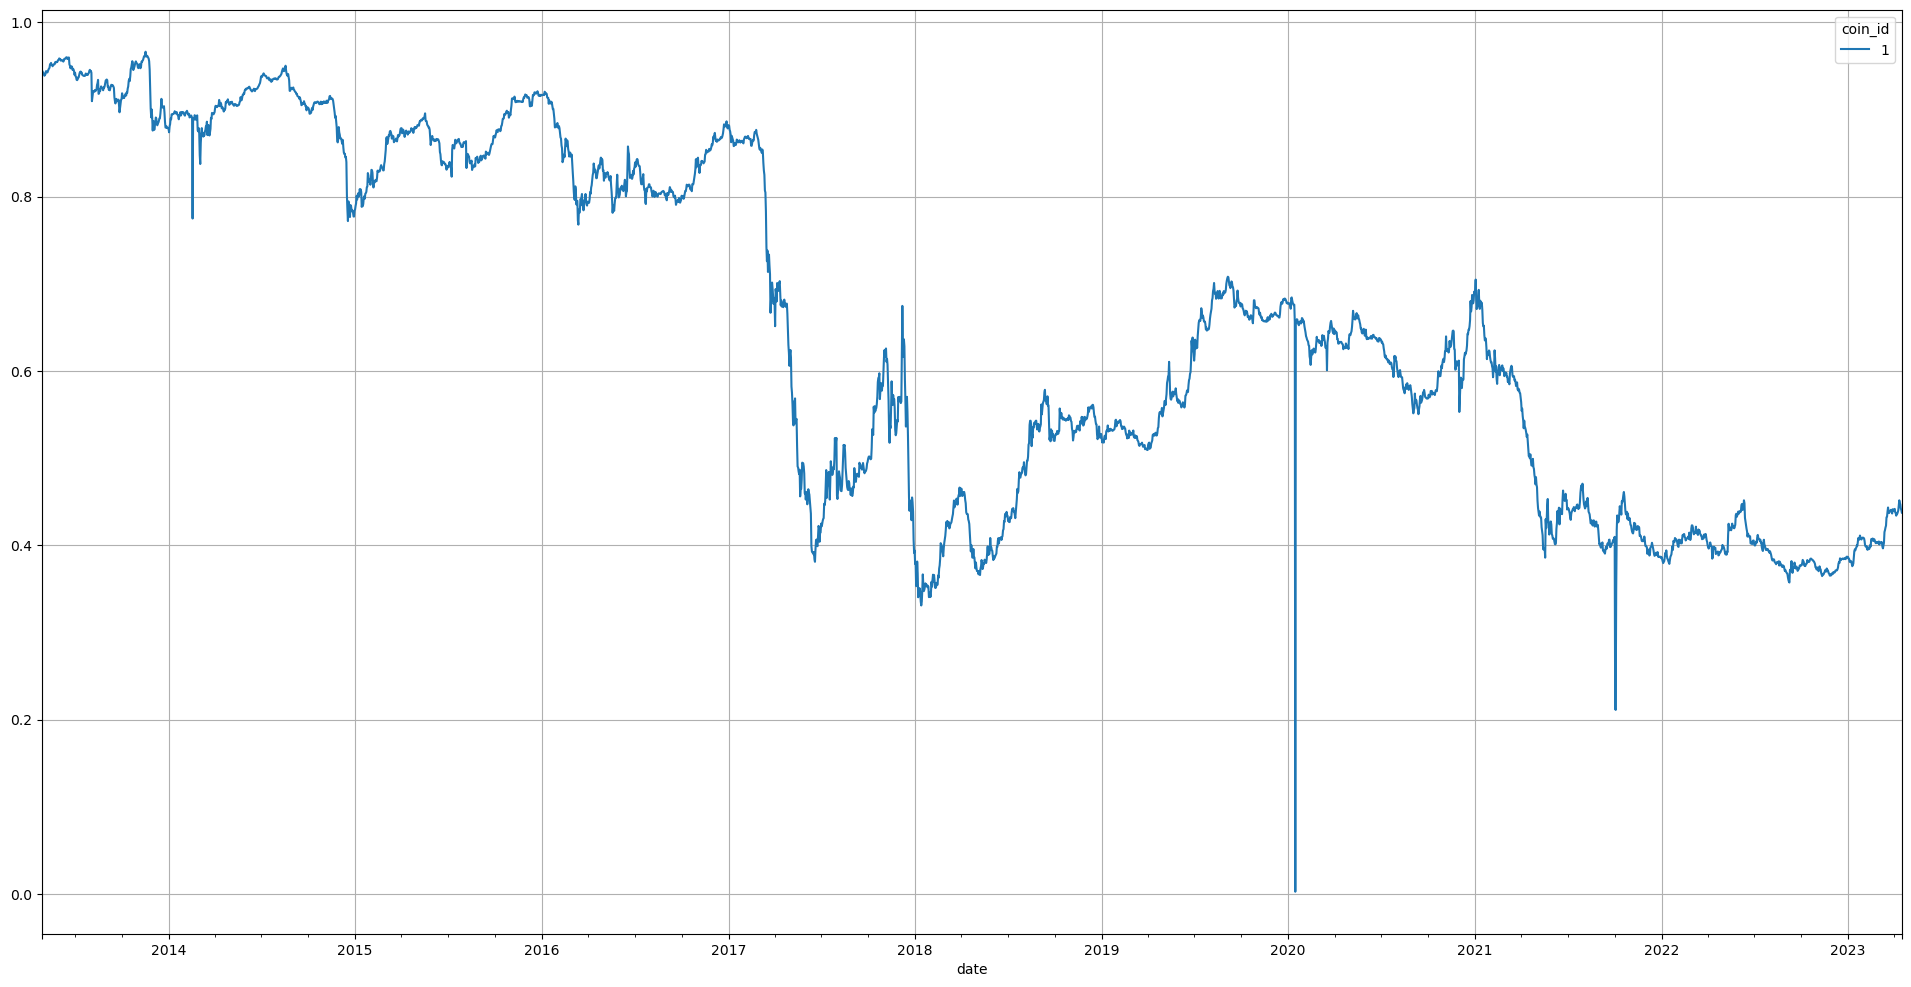

In [24]:
weight[["1"]].plot(figsize=(24,12))
plt.grid();

##### BTC weight가 갑자기 튀는 3개의 구간

2014-02-17 / 2020-01-15 / 2021-10-02,3

##### 2021년

In [25]:
weight_btc = weight[["1"]]

weight_btc.loc["2021-10-01":"2021-10-05"] # 갑자기 21%가 된다

coin_id,1
date,
2021-10-01,0.409645
2021-10-02,0.212335
2021-10-03,0.211050
2021-10-04,0.349275
2021-10-05,0.417431


In [16]:
# 10월 2일 점검
# 찾았다 7271 넌 뭐니..? : Starname,IOV
weight.loc["2021-10-02"].sort_values(ascending=False)

coin_id
7271    0.475768
1       0.212342
1027    0.094393
5015    0.017118
2010    0.017040
          ...   
999          NaN
9991         NaN
9996         NaN
9997         NaN
9998         NaN
Name: 2021-10-02 00:00:00, Length: 10616, dtype: float64

In [17]:
# 10월 3일 점검
# 찾았다 7271 넌 뭐니..? : Starname,IOV
weight.loc["2021-10-03"].sort_values(ascending=False)

coin_id
7271    0.478472
1       0.211056
1027    0.093607
5015    0.016868
1839    0.016829
          ...   
999          NaN
9991         NaN
9996         NaN
9997         NaN
9998         NaN
Name: 2021-10-03 00:00:00, Length: 10616, dtype: float64

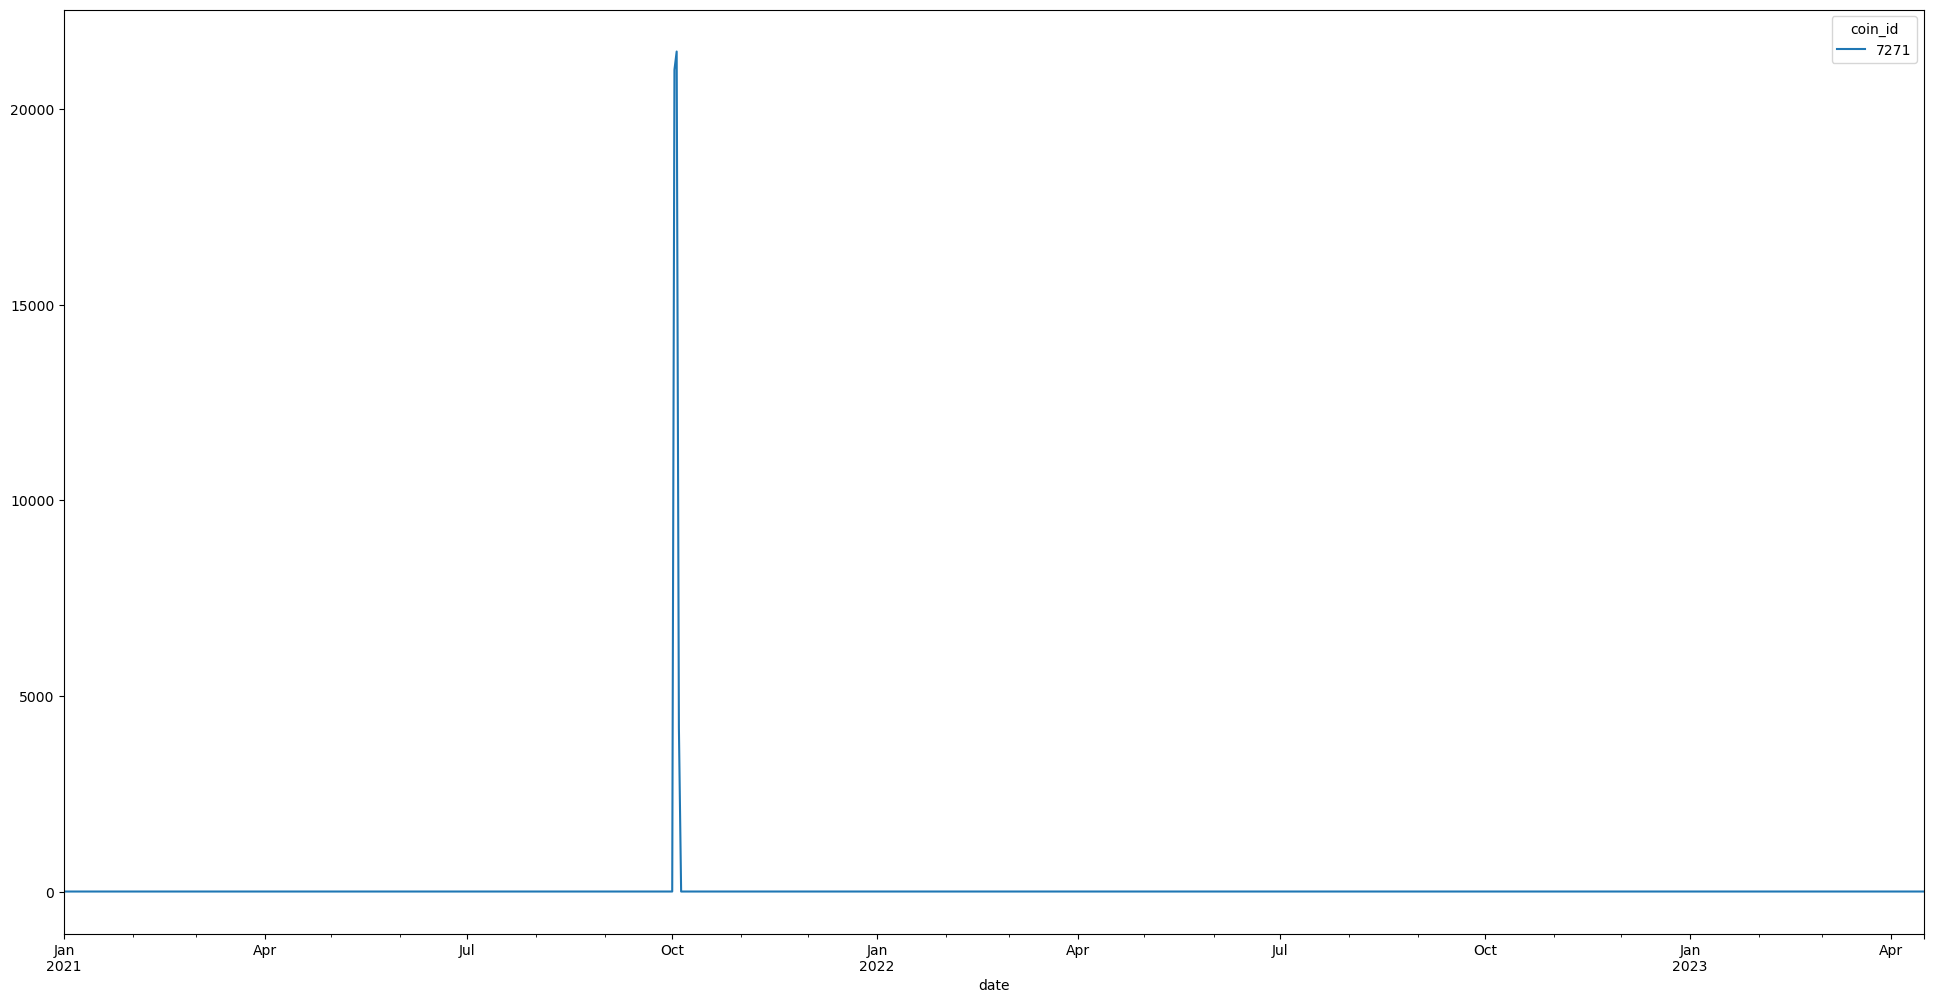

In [18]:
# coingecko와 데이터가 다름..
close[["7271"]].loc["2021":"2023"].plot(figsize=(24,12));

In [19]:
# coingecko에서 찾은 데이터
close_pp.loc["2021-10-02","7271"] = 0.065588
mktcap_pp.loc["2021-10-02","7271"] = 9_236_265

close_pp.loc["2021-10-03","7271"] = 0.072875
mktcap_pp.loc["2021-10-03","7271"] = 9_822_063

close_pp.loc["2021-10-04","7271"] = 0.071590
mktcap_pp.loc["2021-10-04","7271"] = 9_640_484

##### 2014년 확인

VOLT(124)가 문제가 있는데, Paper에서도 클리닝 하지 않고 사용한 것 같다.

VOLT를 드랍하고 마켓 인덱스를 구하면 결과가 다르게 나온다

In [26]:
weight_btc.loc["2014-02-15":"2014-02-19"]

coin_id,1
date,
2014-02-15,0.892334
2014-02-16,0.890546
2014-02-17,0.774955
2014-02-18,0.890068
2014-02-19,0.888952


In [27]:
# 찾았다 124 넌 뭐니..? : Electric,VOLT
weight.loc["2014-02-17"].sort_values(ascending=False)

coin_id
1       0.774955
124     0.130366
2       0.039853
52      0.011921
5       0.008492
          ...   
999          NaN
9991         NaN
9996         NaN
9997         NaN
9998         NaN
Name: 2014-02-17 00:00:00, Length: 10616, dtype: float64

Text(0.5, 1.0, 'Marketcap of VOLT')

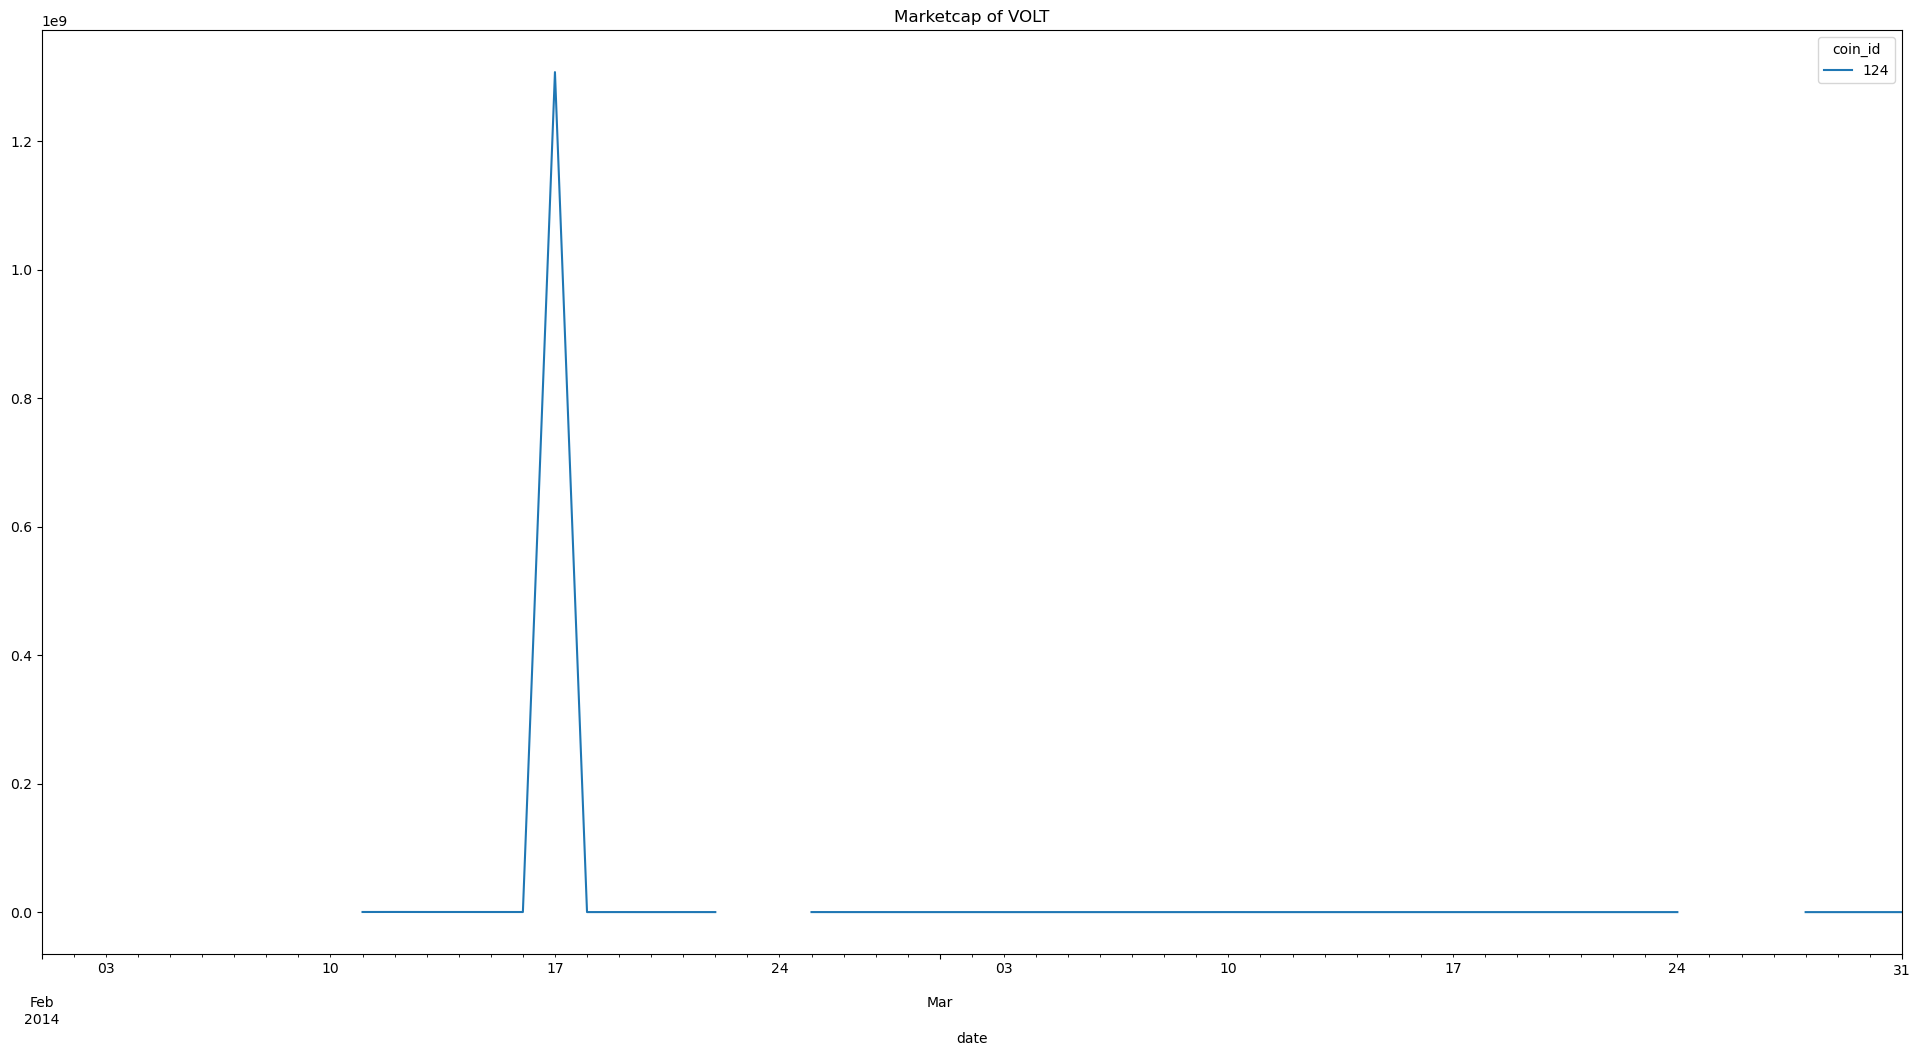

In [32]:
mktcap[["124"]].loc["2014-02":"2014-03"].plot(figsize=(24,12))
plt.title("Marketcap of VOLT")

# 근데 VOLT는 paper에서도 클리닝을 안하고 그대로 사용한 것 같음 (VOLT를 드랍하면 결과가 달라진다)

##### 2020년 확인

In [23]:
# 말도 안되는 0.002의 weight가 나온다
weight_btc.loc["2020-01-14":"2020-01-16"]

coin_id,1
date,
2020-01-14,0.656882
2020-01-15,0.002440
2020-01-16,0.658715


In [24]:
# 찾았다 5115 넌 뭐니..? : TerraKRW,KRT
weight.loc["2020-01-15"].sort_values(ascending=False)

coin_id
5115    0.996296
1       0.002440
1027    0.000277
52      0.000155
1831    0.000094
          ...   
999          NaN
9991         NaN
9996         NaN
9997         NaN
9998         NaN
Name: 2020-01-15 00:00:00, Length: 10616, dtype: float64

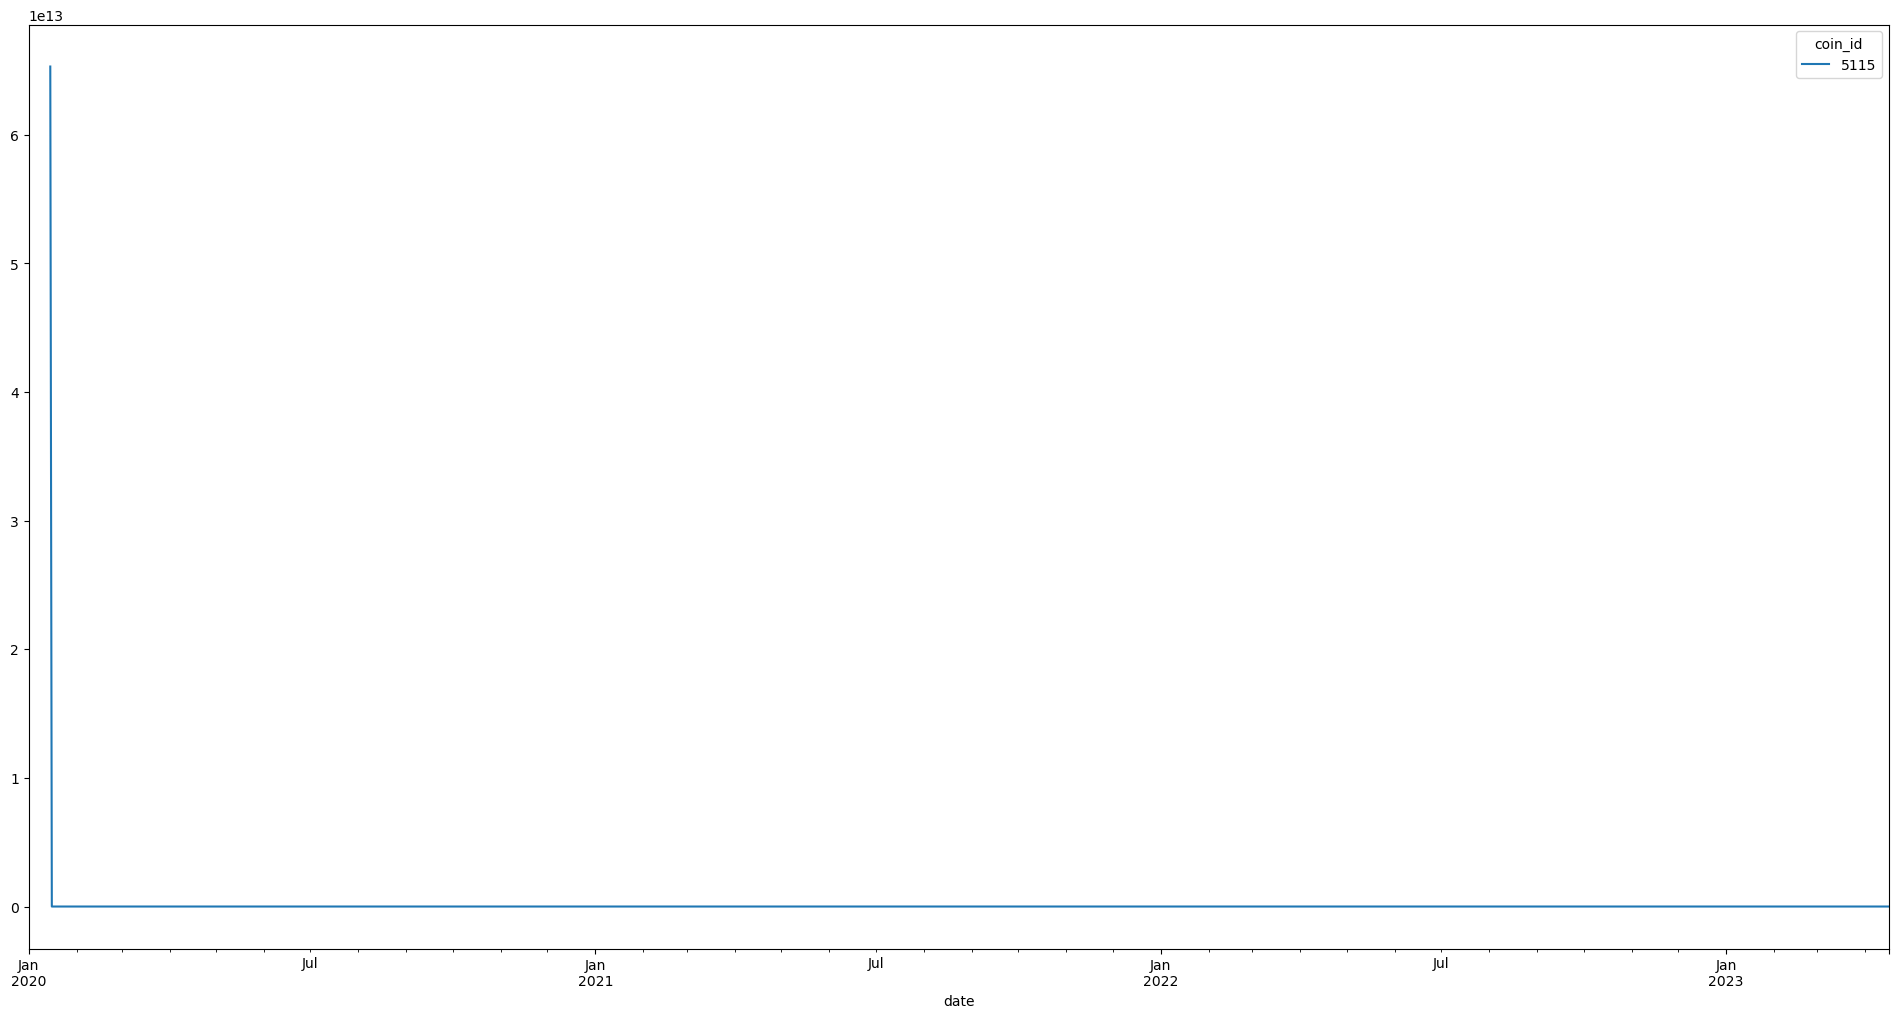

In [25]:
mktcap[["5115"]].loc["2020":].plot(figsize=(24,12));

In [35]:
mktcap[["5115"]].loc["2020-01-13":"2020-01-18"]

coin_id,5115
date,
2020-01-13,NaN
2020-01-14,NaN
2020-01-15,6.531307e+13
2020-01-16,0.000000e+00
2020-01-17,0.000000e+00
2020-01-18,0.000000e+00


In [26]:
mktcap[["5115"]].loc[~mktcap[["5115"]].isna().values]

# 이거는 그냥 0으로 주면 될 듯...

coin_id,5115
date,
2020-01-15,6.531307e+13
2020-01-16,0.000000e+00
2020-01-17,0.000000e+00
2020-01-18,0.000000e+00
2020-01-19,0.000000e+00
...,...
2023-04-12,2.477842e+07
2023-04-13,2.319576e+07
2023-04-14,2.629293e+07


In [27]:
# 수정
mktcap_pp.loc["2020-01-15","5115"] = 0.0

### Return 계산하다 발견한 이상한 값 점검

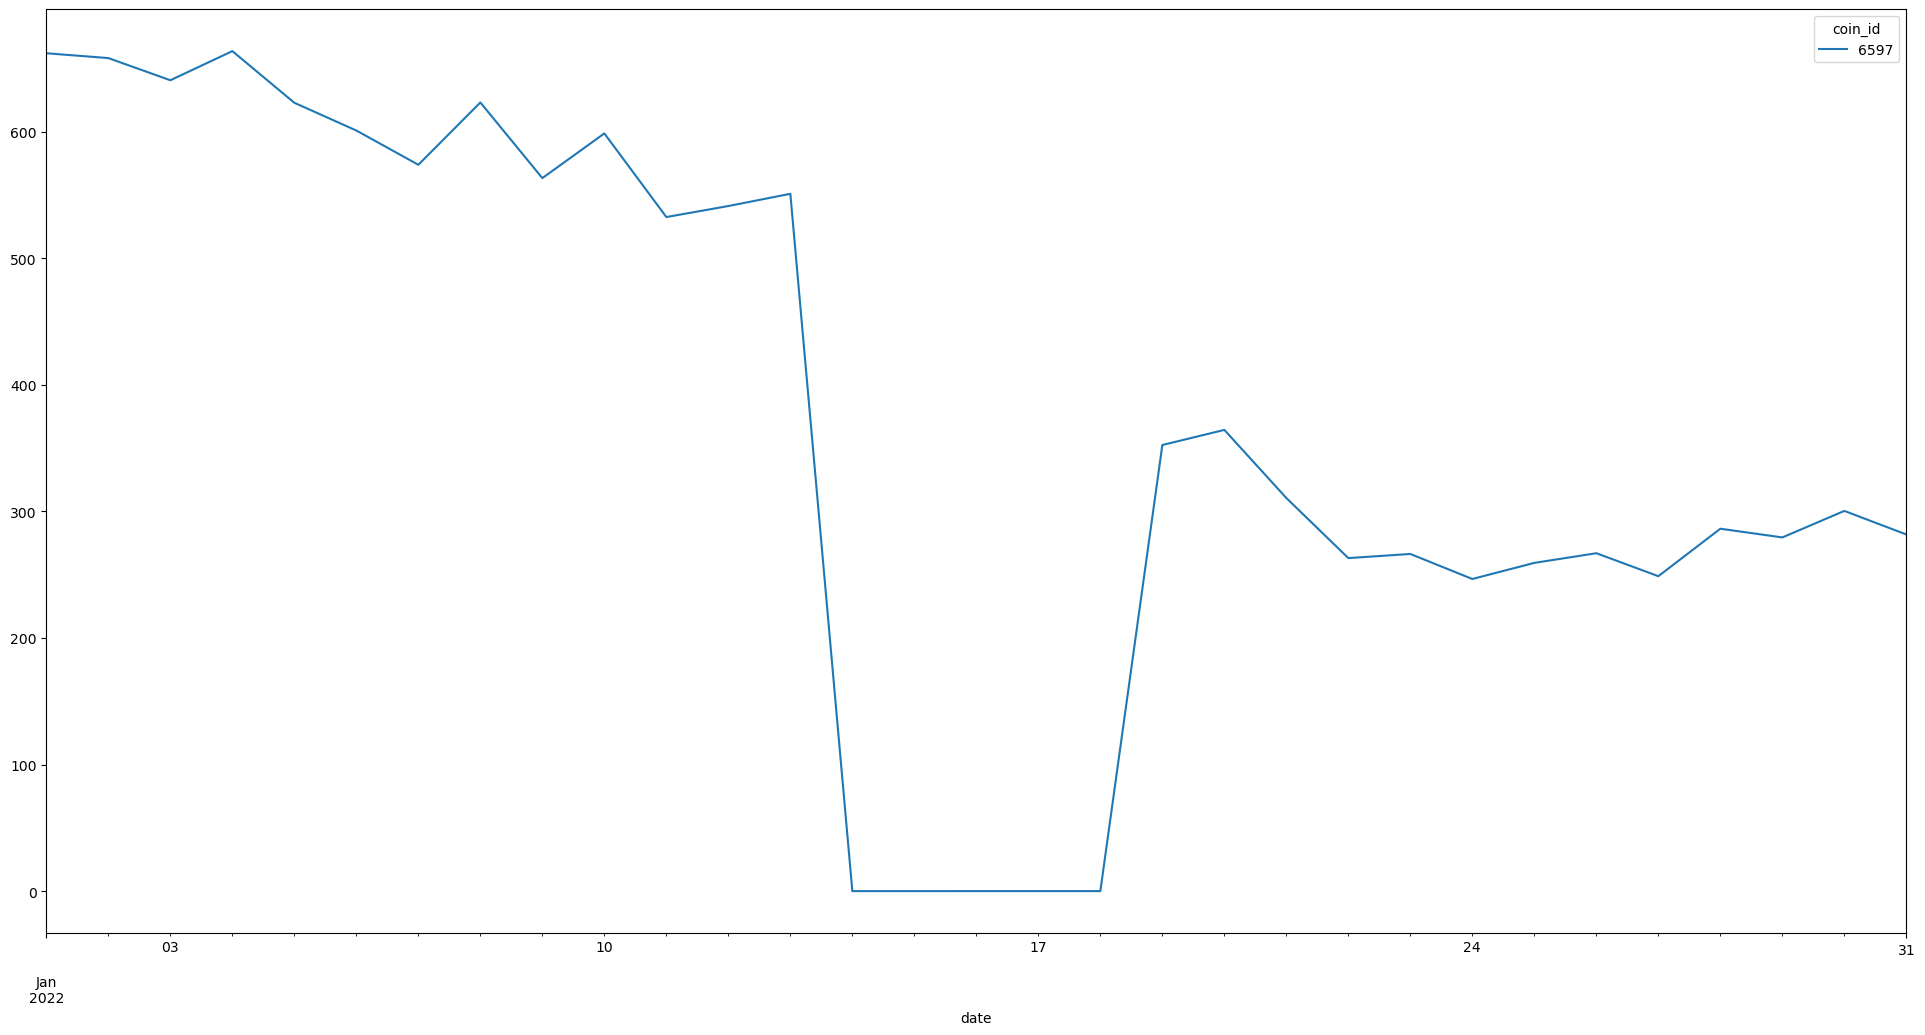

In [28]:
# 6597    Degenerator Meme,MEME (Weekly Momentum Q1에서 발견)
close_pp[["6597"]].loc["2022-01"].plot(figsize=(24,12));

In [29]:
close_pp[["6597"]].loc["2022-01-13":"2022-01-20"] # 이러니 수익률이 어마어마하게 튄다

coin_id,6597
date,
2022-01-13,550.810791
2022-01-14,0.008173
2022-01-15,0.006762
2022-01-16,0.014676
2022-01-17,0.018260
2022-01-18,0.029162
2022-01-19,352.381960
2022-01-20,364.335295


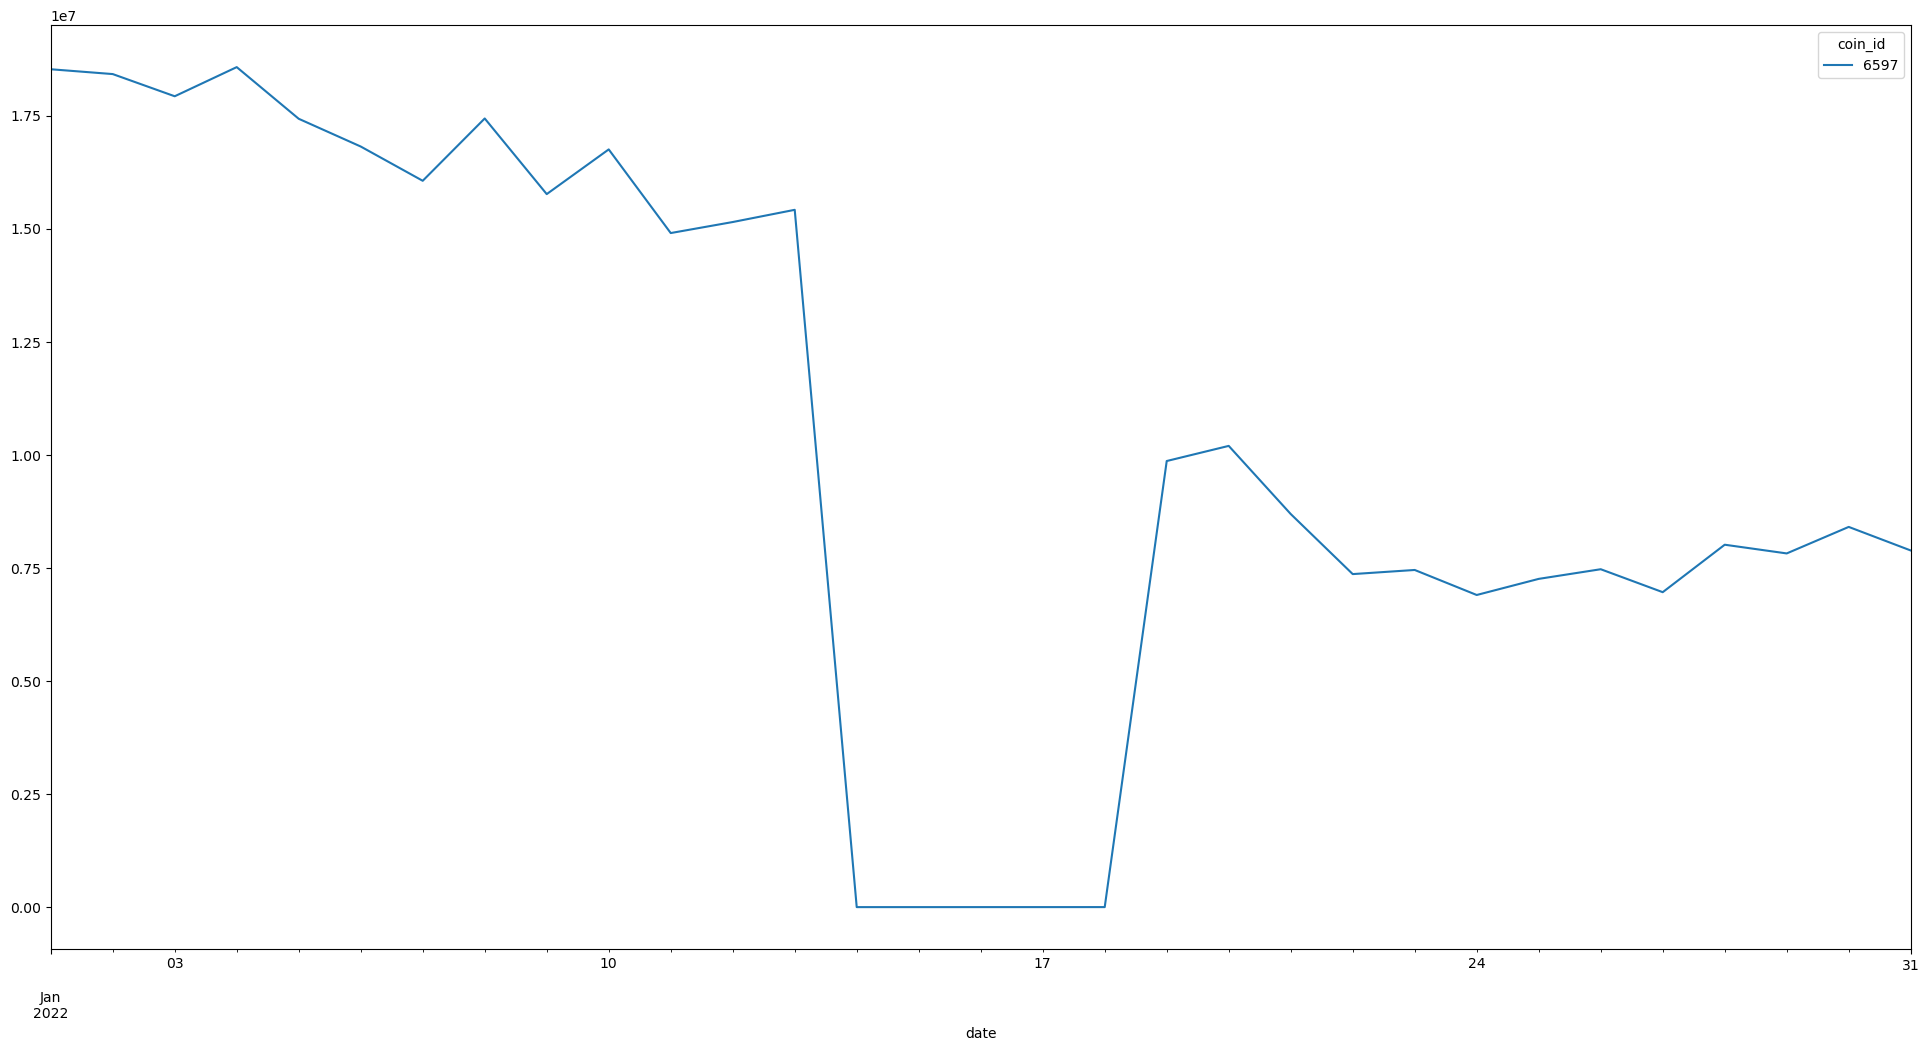

In [30]:
mktcap_pp[["6597"]].loc["2022-01"].plot(figsize=(24,12));

2022-04-10    1220.048560

5분위 모멘텀 계산중 Q1에서 발견...

In [39]:
s = (rtn_daily * mktcap_mask)
s.loc["2022-04-10"].sort_values(ascending=False)
# 1281:ION,ION

coin_id
1281    1220.048560
2444       6.225361
2178       2.847632
2001       2.633793
3913       1.876070
           ...     
999             NaN
9991            NaN
9996            NaN
9997            NaN
9998            NaN
Name: 2022-04-10 00:00:00, Length: 10616, dtype: float64

In [45]:
# 10일 11일 두개가 이상하다...
close.loc["2022-04-08":"2022-04-12","1281"]

date
2022-04-08       0.479883
2022-04-09       4.221500
2022-04-10    5154.656979
2022-04-11    4711.266556
2022-04-12       0.056397
Name: 1281, dtype: float64

In [46]:
mktcap.loc["2022-04-08":"2022-04-12","1281"]

date
2022-04-08    6.633423e+06
2022-04-09    5.835572e+07
2022-04-10    7.125751e+10
2022-04-11    6.513028e+10
2022-04-12    7.796746e+05
Name: 1281, dtype: float64

### 수정을 마친 weight 다시 점검

In [31]:
mktcap_mask = (mktcap_pp > 1_000_000).replace({True:1,
                                            False:np.nan})

mktcap_screened = (mktcap_pp * mktcap_mask)

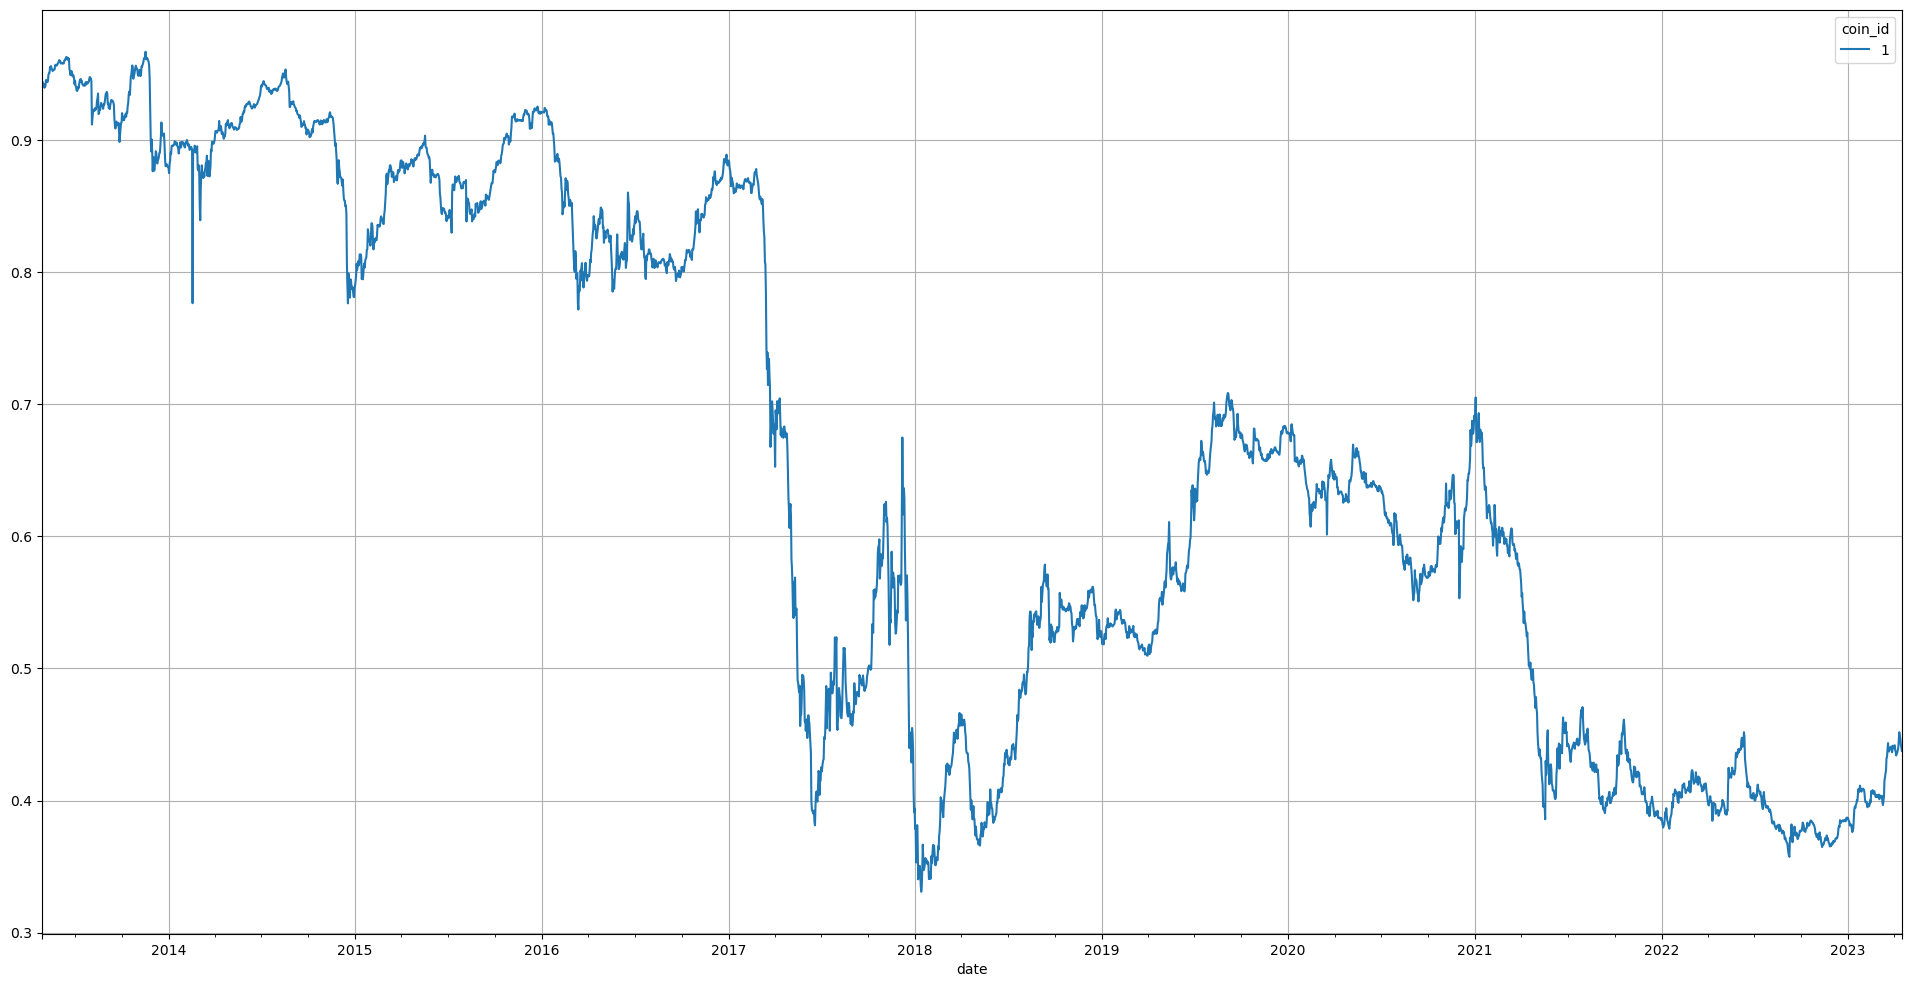

In [32]:
new_weight = mktcap_screened.apply(lambda x: x / np.nansum(x), axis=1)
new_weight[["1"]].plot(figsize=(24,12))
plt.grid();
# 얼추 튀는 날이 있긴 하지만, 클리닝이 나름 잘 되었다

### 수정된 데이터로 마켓 리턴을 찍어보자

In [33]:
daily_rtn_pp = close_pp.replace(0, np.nan) \
                       .pct_change(fill_method=None)

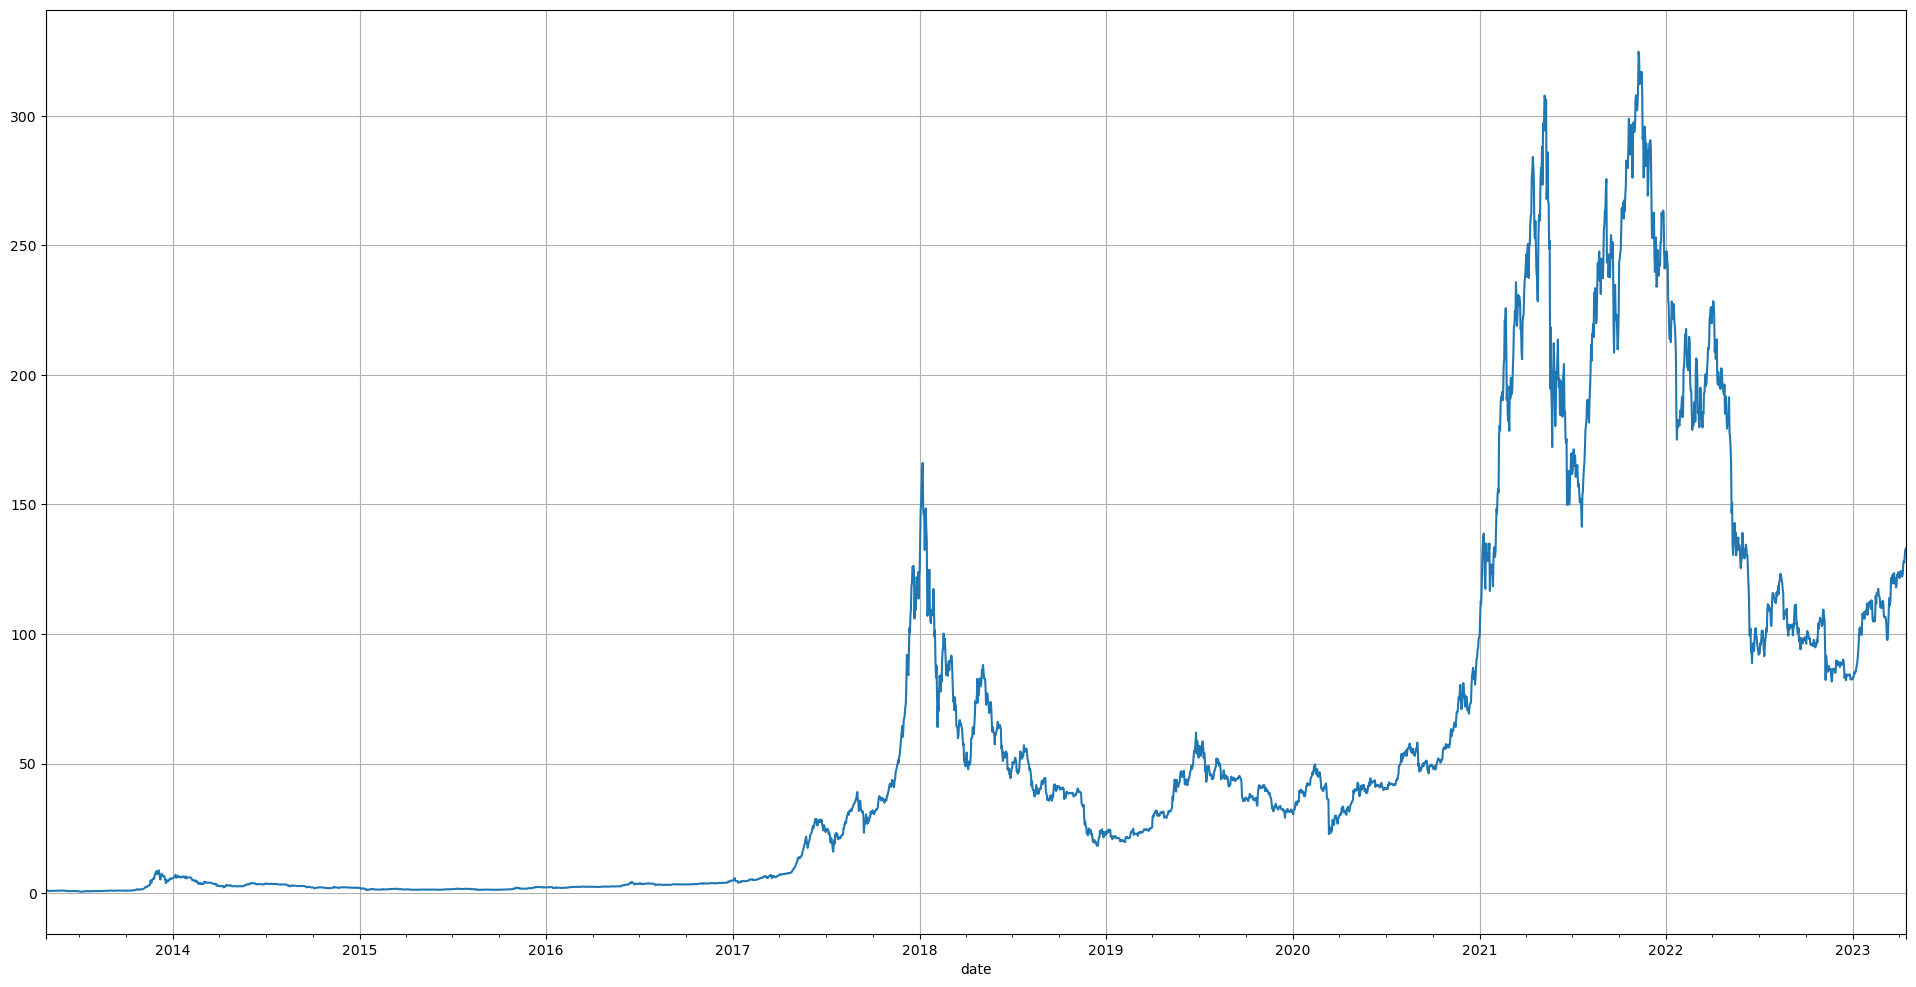

In [34]:
mkt_rtn_pp = (daily_rtn_pp * new_weight.shift(1)).sum(1)
(mkt_rtn_pp + 1).cumprod().plot(figsize=(24,12))
plt.grid();

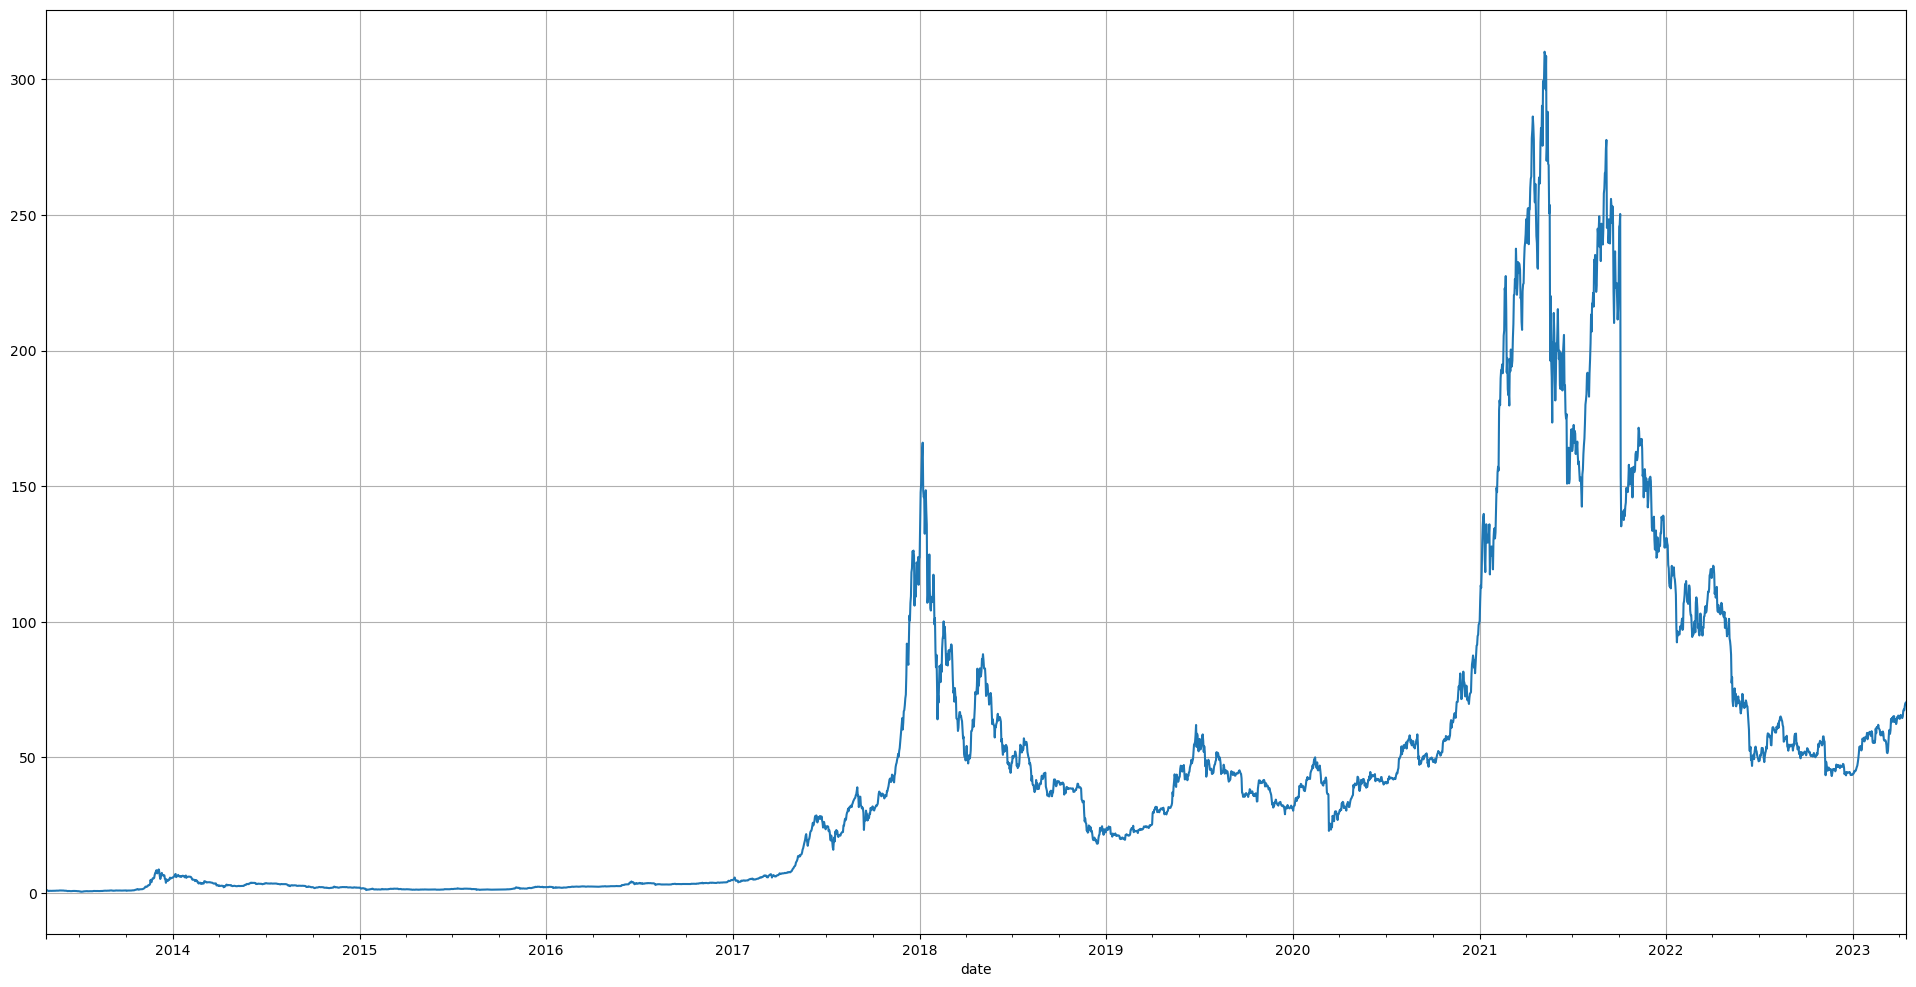

In [35]:
# 클리닝 안한 경우
((rtn_daily * weight.shift(1)).sum(1) + 1).cumprod().plot(figsize=(24,12))
plt.grid();

### S&P coinmarket index와 비교

In [36]:
sap = pd.read_excel("s&p_coinmkt_index.xls", index_col=0,
                      parse_dates=True)

start = sap.index[0]
end = sap.index[-1]

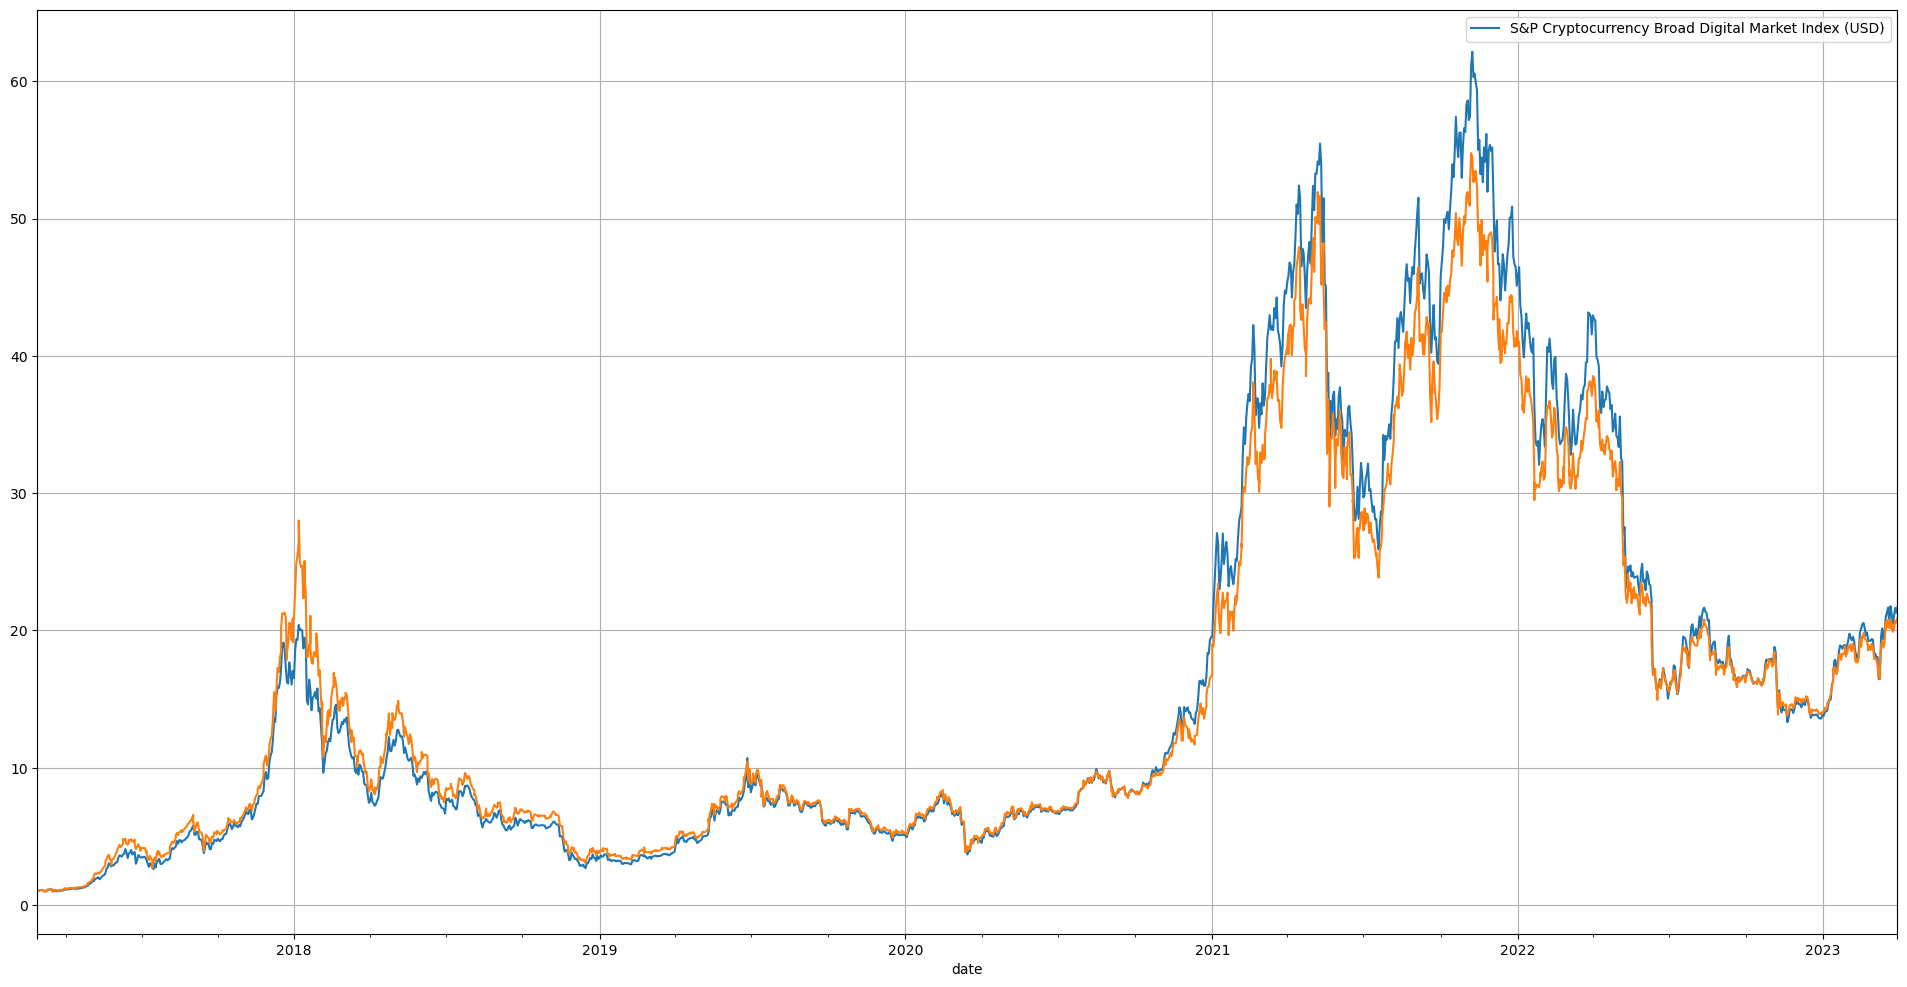

In [37]:
fig, ax = plt.subplots(1,1)

# Plot: S&P coinmarket index
(sap / 100).plot(figsize=(24,12), ax=ax);
# Plot: Our market return
(mkt_rtn_pp.loc[start:end] + 1).cumprod().plot(figsize=(24,12))
plt.grid();

# 클리닝한 데이터가 매우 믿을만하다고 생각할 수 있음

### Cleaning 된 데이터 저장

In [38]:
close_pp.to_pickle("close_pp.pickle")
mktcap_pp.to_pickle("mktcap_pp.pickle")